In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
ratings = pd.read_csv('ml-latest-small/ml-latest-small/ratings1.csv')
movies = pd.read_csv('ml-latest-small/ml-latest-small/movies1.csv')

In [6]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 59779
Number of unique movieId's: 3253
Number of unique users: 610
Average number of ratings per user: 98.0
Average number of ratings per movie: 18.38


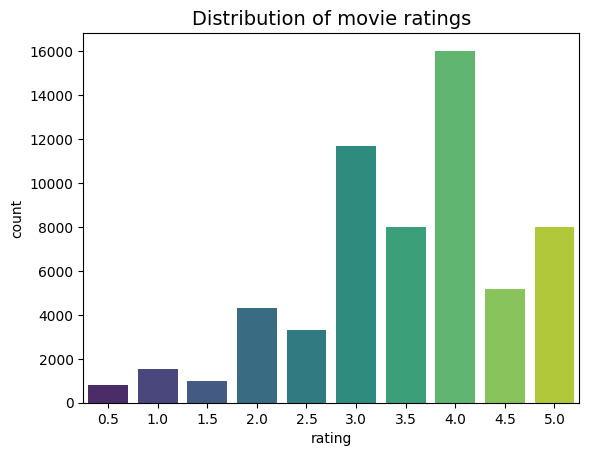

In [7]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [8]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.52.
Mean rating per user: 3.67.


In [9]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

Night of the Living Dead    412
The Fugitive                382
The Mummy                   376
Ocean's Eleven              334
Forrest Gump                329
The Shawshank Redemption    317
Pulp Fiction                307
The Silence of the Lambs    279
The Matrix                  278
The Three Musketeers        272
Name: title, dtype: int64

In [10]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
5016,605,War Room,Drama


In [11]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
2422,71,Come and See,Drama|War


In [12]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
27787,305,71,5.0,1516132019
52506,567,71,5.0,1525282316


In [13]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean']) #Bayesian Average
movie_stats.head()

,count,mean
movieId,,
1,317,4.429022
2,192,4.289062
5,58,4.163793
6,87,4.155172
9,2,2.500000


In [14]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 18.38
Average rating for a given movie: 3.27


In [15]:
lamerica = pd.Series([5, 5])
bayesian_avg(lamerica)

3.44

In [16]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [17]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
0,1,317,4.429022,4.366,The Shawshank Redemption
1,2,192,4.289062,4.200,The Godfather
16,22,218,4.272936,4.195,Fight Club
57,130,204,4.237745,4.158,The Usual Suspects
8,12,307,4.197068,4.145,Pulp Fiction


In [18]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
3444,9032,19,1.605263,2.424,Speed 2: Cruise Control
402,962,49,2.142857,2.450,Godzilla
401,962,49,2.142857,2.450,Godzilla
400,962,49,2.142857,2.450,Godzilla
3449,9038,19,1.657895,2.451,Battlefield Earth


In [19]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,319,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2106,Jumanji,"[Adventure, Children, Fantasy]"
2,8202,Grumpier Old Men,"[Comedy, Romance]"
3,3982,Father of the Bride Part II,[Comedy]
4,405,Heat,"[Action, Crime, Thriller]"


In [20]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 881,
         'Animation': 371,
         'Children': 436,
         'Comedy': 1955,
         'Fantasy': 539,
         'Romance': 914,
         'Action': 1326,
         'Crime': 803,
         'Thriller': 1440,
         'Drama': 2434,
         'Horror': 663,
         'Mystery': 410,
         'Sci-Fi': 658,
         'Musical': 164,
         'War': 204,
         'Documentary': 11,
         'IMAX': 144,
         'Western': 98,
         'Film-Noir': 54,
         '(no genres listed)': 8})

In [21]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 2434), ('Comedy', 1955), ('Thriller', 1440), ('Action', 1326), ('Romance', 914)]


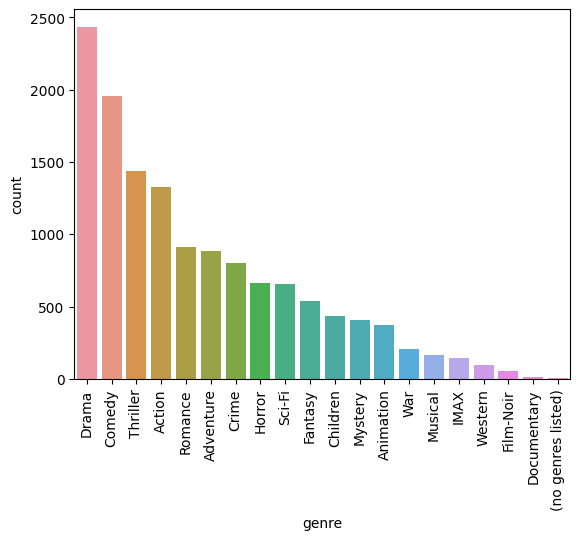

In [22]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

In [23]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [24]:
X.shape

(610, 3253)

In [25]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 2.96%


In [26]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [27]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 1283 movies.
Least active user rated 8 movies.


In [28]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

3253

In [29]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


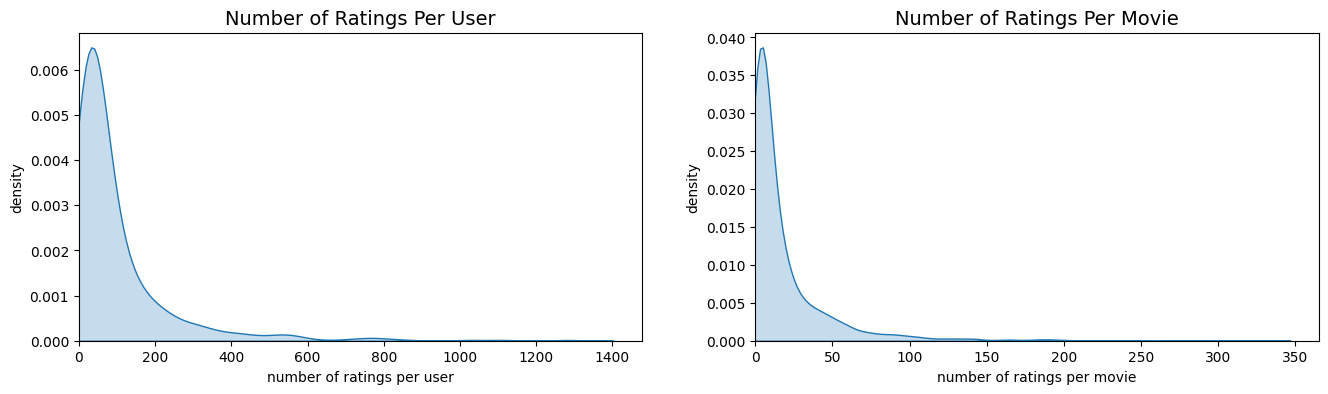

In [31]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

In [32]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [33]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[14, 12, 50, 130, 22, 112, 7633, 13, 2]

In [34]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched The Shawshank Redemption:
Forrest Gump
Pulp Fiction
The Silence of the Lambs
The Usual Suspects
Fight Club
The Matrix
Beavis and Butt-Head Do America
The Lord of the Rings: The Return of the King
The Godfather


In [35]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched The Shawshank Redemption:
Forrest Gump
Pulp Fiction
The Usual Suspects
The Silence of the Lambs
Fight Club
Beavis and Butt-Head Do America
Good Will Hunting
The Lord of the Rings: The Return of the King
The Fugitive
